# Assignment 6 - Group Assignment 1

## A bit of info before you start.


> ***First and foremost, dont use AI to code. Use it to understand and then write code yourself. Use AI to verify if the code you wrote it correct, that will help you learn far far more.***

> ***Use cv2 functions only or atleast wherever possible.***

> **This assignment marks 1/3rd of your project. And hence, it is the first part of the final submission from your team.**







## Create a DataLoader Class

Use the pytorch docs sent on group and deepen your understanding using sample practice, or even AI.

Finally, create a dataloader for the Fruits-360 dataset ( https://www.kaggle.com/datasets/moltean/fruits ).
In <code>__getitem__</code> , include the processing to create LBP image, canny image, and find the 6 color features and 6 shape features.
Best implementation should include a proper division of tasks between the method itself and utility functions.
Also brainstorm about the data structures you use to process and pass the info. Use cv2 functions for best performance.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

DATASET

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class SimpleImageDataset(Dataset):
  def __init__(self,root_dir):
    self.root_dir = root_dir
    self.classes = [
        d for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ]
    #Indexing the classes
    self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

    #Loading the images in a list
    self.images = []
    for cls in self.classes:
      cls_dir = os.path.join(root_dir,cls)
      for img in os.listdir(cls_dir):
        if img.lower().endswith(('.png','.jpeg','.jpg')):
          self.images.append((os.path.join(cls_dir,img), self.class_to_idx[cls]))

    self.transform = transforms.Compose([transforms.ToTensor()])


  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    img_path, label = self.images[idx]
    image = Image.open(img_path).convert('RGB')

    #Creating grayscale image to be passed to necessary functions
    bgr_img=cv2.imread(img_path)
    gray_img=cv2.cvtColor(bgr_img,cv2.COLOR_BGR2GRAY)

    #LBP and Canny images. LBP uses self-implemented function
    lbp_img=get_lbp_image(gray_img)
    canny_img=cv2.Canny(gray_img,100,200)

    mask=create_fruit_mask(bgr_img) #Creating mask since shape features function requires mask

    color_features=extract_color_features(bgr_img)
    shape_features=extract_shape_features_from_mask(mask)

    #Converting images and features to tensors so they can be batched and used by PyTorch models
    image = self.transform(image)
    lbp=torch.tensor(lbp_img,dtype=torch.float32).unsqueeze(0)
    canny=torch.tensor(canny_img,dtype=torch.float32).unsqueeze(0)
    shape=torch.tensor(shape_features,dtype=torch.float32)
    color=torch.tensor(color_features,dtype=torch.float32)
    label=torch.tensor(label)

    return image,lbp,canny,shape,color,label


In [ ]:
#@title LBP function
#function1 - to get the lbp image of the grayscale img
def get_lbp_image(gray):

    lbp = np.zeros_like(gray, dtype=np.uint8)
    neighbors = [
        (-1,-1),(-1,0),(-1,1),
        (0,1),(1,1),(1,0),(1,-1),(0,-1)
    ]
    for idx, (dy, dx) in enumerate(neighbors):
        #shifting image to align neighbor pixels with center pixels
        shifted = np.roll(np.roll(gray, dy, axis=0), dx, axis=1)
        val = (shifted >= gray).astype(np.uint8)
        lbp |= (val<<(7-idx))

    return lbp

In [ ]:
#@title BINARY IMAGE CONVERTER AND SEGMENTATION
# this function is used for the segmentation ,binary conversion and masking process
def create_fruit_mask(bgr_img):

    hsv_img=cv2.cvtColor(bgr_img,cv2.COLOR_BGR2HSV)#this part converts the BGR form of image to HSV
    #because for the shape feature extraction there is no need for the BGR form of image

    # this function aactually converts the white bacckground check to limits
    lower_white=np.array([0, 0, 200])
    upper_white=np.array([180, 40, 255])

    white_mask=cv2.inRange(hsv_img, lower_white, upper_white)# detect white background that is under the 0-255 limit range


    fruit_mask=cv2.bitwise_not(white_mask)# invert mask so fruit becomes white makes

    # Morphological operations to clean mask
    kernel=np.ones((5, 5), np.uint8)

    fruit_mask=cv2.morphologyEx(fruit_mask,cv2.MORPH_CLOSE,kernel)
    fruit_mask=cv2.morphologyEx(fruit_mask, cv2.MORPH_OPEN,kernel)

    return fruit_mask

In [ ]:
#@title EXTRACTION OF SHAPE FEATURE
#This function is used for the extraction of the image made from the create image function
def extract_shape_features_from_mask(mask):
    # find contours from binary masking
    contours, _ =cv2.findContours(
        mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )


    if len(contours) == 0:# if no countours (which are assume it as the boudary of the image given)
        return np.zeros(8, dtype=np.float32)
    c = max(contours, key=cv2.contourArea)# selecting the largest contour that largest countour will be the fruit itself
    # 1️ area
    area = cv2.contourArea(c)


    # 2️ perimeter
    perimeter = cv2.arcLength(c, True)
    # 3️ bounding box width and height
    x,y,w,h=cv2.boundingRect(c)


    # 4️ aspect ratio
    aspect_ratio=w/h if h !=0 else 0

    # 5️ circularity
    circularity=(4*np.pi * area)/(perimeter ** 2)if perimeter !=0 else 0

    #6 Hu Moments (in Log scale)
    moments= cv2.moments(c)#calculates the image moments and return values that represent central moment and spatial moments
    hu_moments= cv2.HuMoments(moments).flatten() #takes the previously calculated moments and now calculates phi_x :Hu Moments
    #as the Hu moments are generally very small , so converting them to log scale
    #log scale= -1* sign(Hu)*log10(abs(Hu))
    phi_1= -1*np.copysign(1.0,hu_moments[0])* np.log10(np.abs(hu_moments[0])) if hu_moments[0]!=0 else 0
    phi_2= -1*np.copysign(1.0,hu_moments[1])* np.log10(np.abs(hu_moments[1])) if hu_moments[1]!=0 else 0


    return np.array([
        area,
        perimeter,
        w,
        h,
        aspect_ratio,
        circularity,phi_1,phi_2
    ], dtype=np.float32)


In [ ]:
#@title COLOR EXTRACTION function
def extract_color_features(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mean, std_dev = cv2.meanStdDev(hsv_img, mask=mask)
    Mean_Hue= mean[0][0]
    Std_Hue= std_dev[0][0]
    Mean_Saturation= mean[1][0]
    Std_Saturation= std_dev[1][0]
    Mean_Value= mean[2][0]
    Std_Value= std_dev[2][0]
    return Mean_Hue,Std_Hue,Mean_Saturation,Std_Saturation,Mean_Value,Std_Value

In [ ]:
import kagglehub
import os

path = kagglehub.dataset_download("moltean/fruits")

root = os.path.join(path,"fruits-360_100x100","fruits-360","Training")

dataset = SimpleImageDataset(root)

loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True
)

for image, lbp, canny, shape, color, label in loader:
    print(image.shape)
    print(label)
    break


Using Colab cache for faster access to the 'fruits' dataset.
torch.Size([2, 3, 100, 100])
tensor([137,  78])


Analyzing Sample: Tomato 5 (Index 77880)
Path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Tomato 5/r2_121_100.jpg


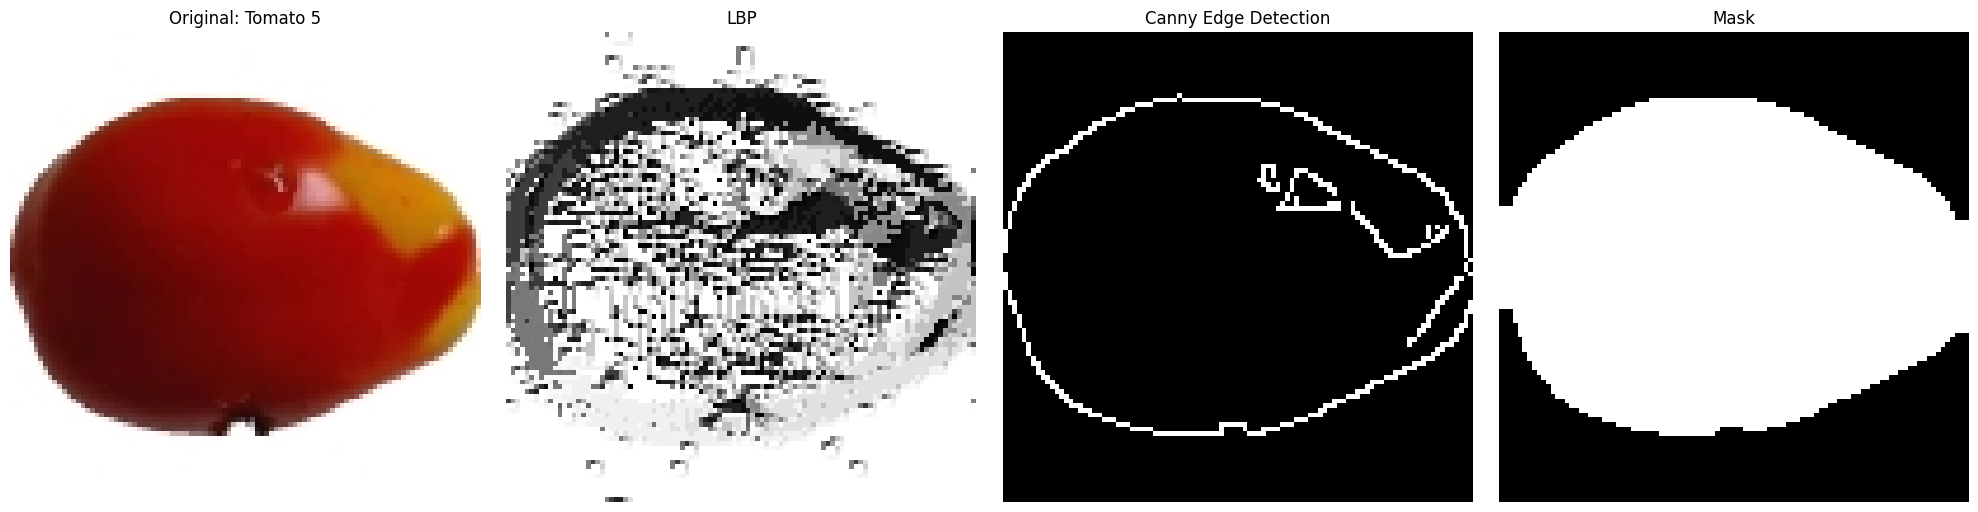


Extracted Feature:
Shape Features: [5.4950000e+03 2.9162238e+02 1.0000000e+02 7.2000000e+01 1.3888888e+00
 8.1196237e-01 7.6872742e-01 2.4735603e+00]
Color Features: (np.float64(6.41218441273326), np.float64(24.569965320495836), np.float64(229.477680204903), np.float64(32.80225983761851), np.float64(129.24021222100257), np.float64(37.08778463321807))


In [ ]:
#@title Applying the functions on a random image(which is part of the dataset)
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np

def visualize_random_sample(dataset):
    # Picking a random index
    idx = random.randint(0, len(dataset) - 1)

    # Retrieving path and label
    img_path, label_idx = dataset.images[idx]
    class_name = dataset.classes[label_idx]

    print(f"Analyzing Sample: {class_name} (Index {idx})")
    print(f"Path: {img_path}")

    # Loading & Processing image for displaying
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # LBP
    lbp = get_lbp_image(gray)

    # Canny edge detection
    canny = cv2.Canny(gray, 100, 200)

    # Creating mask
    mask = create_fruit_mask(img_bgr)

    # Extracting the shape and colour features
    shape_feats = extract_shape_features_from_mask(mask)
    color_feats = extract_color_features(img_bgr)

    # Plotting the results
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original Image
    axes[0].imshow(img_rgb)
    axes[0].set_title(f"Original: {class_name}")
    axes[0].axis('off')

    # LBP
    axes[1].imshow(lbp, cmap='gray')
    axes[1].set_title("LBP")
    axes[1].axis('off')

    # Canny Edge
    axes[2].imshow(canny, cmap='gray')
    axes[2].set_title("Canny Edge Detection")
    axes[2].axis('off')

    # Mask
    axes[3].imshow(mask, cmap='gray')
    axes[3].set_title("Mask")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

    # Printing the extracted features
    print("\nExtracted Feature:")
    print(f"Shape Features: {shape_feats}")
    print(f"Color Features: {color_feats}")

# Running the function
visualize_random_sample(dataset)